# Optimizing the check for overlapping features
---

### Overview
Currently checking for overlap by checking if each feature's bounding box overlaps with every other feature's bounding box. Although we are only checking unique combinations/pairs of bounding boxes, the algorithm is still $O(n^2)$ given that the number of combinations scales with

\begin{equation}
{}_n C_2 = \frac{n!}{2(n-2)!}
\end{equation}

Here we'll look at implementing a more efficient method, cell listing [1] ($O(n)$). Basically involves subdividing the spatial domain into cells (wider than the threshold distance) and then checking for overlap among only the features in each cell (and the neighboring cells).

[1] https://en.wikipedia.org/wiki/Cell_lists

In [1]:
from itertools import combinations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

%matplotlib inline

### Check if two boxes overlap
(This part is fine I think)

In [2]:
def bboxes_overlap(bbox_1, bbox_2):
    """Determines if two bounding boxes overlap or coincide

    Parameters
    ----------
    bbox_1 : array-like (or 4-tuple)
        1st bounding box
        convention: (x_min, y_min, x_max, y_max)
    bbox_2 : array-like (or 4-tuple)
        2nd bounding box
        convention: (x_min, y_min, x_max, y_max)

    Returns
    -------
    overlap : bool
        True if bounding boxes overlap / coincide
        False otherwise

    References
    ----------
    [1] https://stackoverflow.com/a/20925869/5285918
    """
    # 2 tiles overlap iff their projections onto both x and y axis overlap
    # Overlap in 1D iff box1_max > box2_min AND box1_min < box2_max
    overlap = ((bbox_1[2] >= bbox_2[0]) & (bbox_1[0] <= bbox_2[2])) & \
              ((bbox_1[3] >= bbox_2[1]) & (bbox_1[1] <= bbox_2[3]))
    return overlap

### Create features and boxes

In [3]:
# Set plane dimensions
Nx, Ny = (100, 100)

# Set bbox size
wx = 10
wy = 10

# Create a random distribution of features
N = 20
X = np.random.RandomState(15).uniform(0, Nx, size=N)
Y = np.random.RandomState(38).uniform(0, Ny, size=N)

# Create DataFrame of features and their bboxes
features = pd.DataFrame({'x': X, 'y': Y})
features['x_min'] = X - wx/2
features['y_min'] = Y - wy/2
features['x_max'] = X + wx/2
features['y_max'] = Y + wy/2

# Sample features
features.head()

,x,y,x_min,y_min,x_max,y_max
0,84.881770,38.477312,79.881770,33.477312,89.881770,43.477312
1,17.889592,85.970785,12.889592,80.970785,22.889592,90.970785
2,5.436321,94.419964,0.436321,89.419964,10.436321,99.419964
3,36.153845,70.282489,31.153845,65.282489,41.153845,75.282489
4,27.540093,63.363410,22.540093,58.363410,32.540093,68.363410


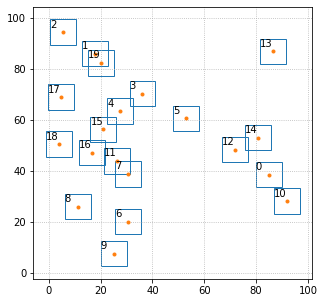

In [4]:
# Make figure
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(features['x'], features['y'], 'o', color='C1', ms=3, lw=0)
for i, row in features.iterrows():
    p = Rectangle((features.loc[i, 'x_min'], features.loc[i, 'y_min']),
                  wx, wy, facecolor='none', lw=1, edgecolor='C0')
    ax.add_patch(p)
    ax.text(features.loc[i, 'x_min'], features.loc[i, 'y_max'],
            f'{i}', ha='left', va='top')
ax.grid(ls=':')

### Cell listing method

In [5]:
# Keep track of overlapping features
overlapping = []
# Define cell parameters
cw = 2*wx  # cell width

# Loop through a grid in x, y to create cells
for x in np.arange(0, Nx, cw):
    for y in np.arange(0, Ny, cw):
        # Create cell
        cell = [x-cw, y-cw, x+2*cw, y+2*cw]
        # Get features in cell
        in_cell = features[((cell[0] < X) & (X < cell[2]) &\
                            (cell[1] < Y) & (Y < cell[3]))]
        # Combinations
        pairs = list(combinations(in_cell.reset_index().values, 2))

        # Loop through pairs of bboxes
        for (bbox_i, bbox_j) in pairs:
            if bboxes_overlap(bbox_i[-4:], bbox_j[-4:]):
                overlapping.append(bbox_i[0])
                overlapping.append(bbox_j[0])

overlapping = np.unique(overlapping)
overlapping

array([ 1.,  3.,  4.,  7., 11., 12., 14., 15., 16., 19.])

### Plot overlapping features

In [6]:
def plot_overlapping_features(features, overlapping, plot_feature_index=False):
    """Plot features showing where bboxes overlap"""
    # Make bboxes
    features['x_min'] = features['x'] - wx/2
    features['y_min'] = features['y'] - wy/2
    features['x_max'] = features['x'] + wx/2
    features['y_max'] = features['y'] + wy/2

    # Make figure
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(features['x'], features['y'], 'o', color='C1', ms=3, lw=0)
    for i, row in features.iterrows():
        if i not in overlapping:
            p = Rectangle((features.loc[i, 'x_min'], features.loc[i, 'y_min']),
                          wx, wy, facecolor='none', lw=1, edgecolor='C0')
        else:
            p = Rectangle((features.loc[i, 'x_min'], features.loc[i, 'y_min']),
                          wx, wy, facecolor='none', lw=1, edgecolor='C3')
        ax.add_patch(p)
        if plot_feature_index:
            ax.text(features.loc[i, 'x_min'], features.loc[i, 'y_max'],
                    f'{i}', ha='left', va='top')
    ax.grid(ls=':')

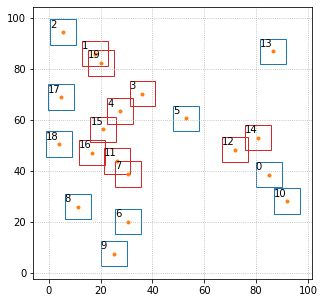

In [7]:
plot_overlapping_features(features, overlapping, plot_feature_index=True)

## Timing comparison
---

In [8]:
from tqdm.notebook import tqdm
from psf_extractor import remove_overlapping_features, remove_overlapping_features_bruteforce

### Bigger feature set

In [9]:
# Set plane dimensions
Nx, Ny = (2000, 2000)

# Create a random distribution of features
N = 300
X = np.random.RandomState(15).uniform(0, Nx, size=N)
Y = np.random.RandomState(38).uniform(0, Ny, size=N)
features = pd.DataFrame({'x': X, 'y': Y})

# Create a bounding box for each bead
wx = 80
wy = 80

### Old method (brute-force)

In [10]:
_, overlapping = remove_overlapping_features_bruteforce(features, wx=wx, wy=wy, return_indices=True)

out = f"Overlapping features... {len(overlapping)} / {N}"
print(out)

  0%|          | 0/44850 [00:00<?, ?it/s]

Overlapping features... 250 / 300


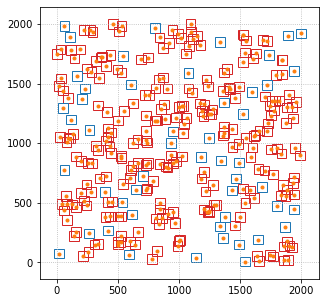

In [11]:
plot_overlapping_features(features, overlapping)

### New method (cell listing)

In [12]:
_, overlapping = remove_overlapping_features(features, wx=wx, wy=wy, return_indices=True)

out = f"Overlapping features... {len(overlapping)} / {N}"
print(out)

  0%|          | 0/14 [00:00<?, ?it/s]

Overlapping features... 250 / 300


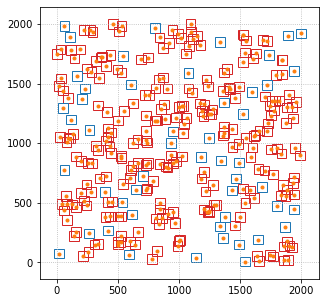

In [13]:
plot_overlapping_features(features, overlapping)